# An AI agent learns to play tic-tac-toe (part 3): training a Q-learning RL agent
*Where we use Q learning to train a reinforcement learning agent to play tic-tac-toe*

*This article is part of a series that lets a computer play tic-tac-toe using reinforcement learning. You can find [all the articles here](https://towardsdatascience.com/tagged/rl-series-paul). The goal is to provide a complete implementation that you can really pick apart and learn reinforcement learning from. It is probably best to read the articles in order. The article including all the code [can be found on Github]().*

# Reinforcement Learning recap
In [part 1](https://towardsdatascience.com/an-ai-agent-plays-tic-tac-toe-part-1-building-the-opponent-to-play-against-bb5af74fded1) and [2](https://towardsdatascience.com/an-ai-agent-plays-tic-tac-toe-part-2-speeding-up-recursive-functions-using-memoization-97253529aea8) of this series we built the opponent for our reinforcement learning (RL) agent, so now we can start working on the actual RL agent itself. Before we go into the actual implementation, I want to spend some time on how Q learning works. 

As we learned in part 1, RL is based on the following key concepts:

![tree](rl_flow.png)

The goal of the agent is to find an efficient **policy**, i.e. what action is optimal in a given situation. In the case of tic-tac-toe this means which position on the board to put our move given the setup on the board. Notice that the policy focuses on long-term **value** Q, not on short term **reward** R. In essence, the policy is the function $Q(S, a)$ which is the long term value Q at state $S$ when we take action $a$. 

# The magic of Q learning
Q-learning is one of the options in defining and learning this function Q. At the core of the approach is the Q-table which stores all the combinations of states and actions. We model the qtable using a dictionary:

In [6]:
from support_functions import keywithmaxval

qtable = {}
qtable['board_state_1'] = {'a': 7.2, 'e': 10, 'h': -6.8, 'i': 0}
qtable['board_state_2'] = {'c': 3.2, 'd': -5.7, 'i': -3.2}
# many many more board states below this
keywithmaxval(qtable['board_state_1'])

'e'

Now when we are in `board_state_1`, we can look at the Q values. The best move we can make is `e` (the center square) as it shows the highest Q value. 

With the Q table defined, our main challenge is to learn the appropriate Q values. The following pseudocode describes the learning process:

    for all episodes:
        if not boardstate in qtable:
            qtable[boardstate] = 0 for all actions
        if (pick random action with chance epsilon)
            pick random action
        else
            pick action with highest q value for boardstate
        Q[boardstate, action] = update_qtable(Q[boardstate, action], 
                                              reward for action, 
                                              Q[next_boardstates])
        tree search makes move 

So we just play a lot of tic-tac-toe games against the tree search, and slowly update the Q values. Some important observations:

- We initialize our qtable with `0`, starting out with no clear indication of what is a good move. 
- If multiple moves exist with the maximum Q value, we choose a random action from those moves. This is to stimulate further exploration. Having multiple maximum values is very common at the start of our training process. 
- We do not always pick the optimal move from the Q table (exploitation), but take a random move with chance $\epsilon$. This is to stimulate the learning process exploring what possible moves can be made, potentially with a high reward. This ensures we do not quickly end up in a local minimum but continuine the search for better moves. This exploitation versus exploration dynamic is an important part of finding a good Q-function. 
- The reward for an action is +10 points if we win, -10 points if we lose and +5 points if we draw. 

The most important step is where we update the Q-table. The following pseudo-equation describes how it works:

    new_Q[S, a] = old_Q[S, a] + instantaneous_reward[S, a] + max(Q for next states after a) 

So the new Q value takes into account the previous Q-value, the reward we got for taking action `a` in state `S` and the Q-values of the possibles moves *after* taking `a` in state `S`. Note that to learn the longterm Q value, we only ever look ahead a single move to the next maximum possible Q value. This is in sharp contrast to the tree search approach which looks ahead all the way to the end of the game. Being able to learn the longterm reward by only looking ahead a single move makes Q-learning rather magical for me. A downside ofcourse is that we need to play a lot of games in order to slowly let all the Q-values spread itself troughout the Q table. 

If we express the update rule [more formally](https://en.wikipedia.org/wiki/Bellman_equation):

\begin{equation}
Q^{new}(s_t, a_t) \leftarrow (1-\alpha) Q(s_t, a_t) + \alpha r_t + \alpha\gamma \max_a(s_{t+1}, a)
\end{equation}

where $(1-\alpha) Q(s_t, a_t)$ equals the old Q-value of taking action $a_t$ in state $s_t$, $\alpha r_t$ equals the instantaneous reward, and 
$\alpha\gamma \max_a(s_{t+1}, a)$ the maximum Q-value we can get for our next move after taking action `a` and ending up in state $s_{t+1}$. A number of important additional coefficients are included in this equation:

- $\alpha$ the learning rate. If the learning rate is zero, the new value is simply the old value. This essentially means the algorithm is not learning anything new. An alpha value of 1 simply discards this old value and completely relies on the new Q value calculated by the other terms. Values in between 0 and 1 allow you to control how fast learning progresses. A balance between learning fast enough, but not getting overly focused on short term gains is part of the challenge. 
- $\gamma$ the discount factor. This determines if we focus mainly on short term reward (small $\gamma$) or on long term value (large $\gamma$). 

# Actually training our agent
With the theoretical foundation out of the way, we can go into actually training our RL agent. The Python script [`train_qlearning.py` on Github]() performs our entire training loop following the pseudo-code training approach we defined earlier. The first dozen lines initialize the tree we [built](https://towardsdatascience.com/an-ai-agent-plays-tic-tac-toe-part-1-building-the-opponent-to-play-against-bb5af74fded1) and [optimized](https://towardsdatascience.com/an-ai-agent-plays-tic-tac-toe-part-2-speeding-up-recursive-functions-using-memoization-97253529aea8), this will serve as the opponent for our RL agent. Next we initialize two objects:

In [ ]:
tictactoe = Tictoe(3)
player_tree = Player(1,                # Player ID, we are 1 and the CPU is -1
                      tree,            # The tree we use for the CPU move
                      alpha = 0.01,    # learning rate
                      gamma = 0.8,     # discount factor
                      epsilon = 0.1)   # exploration rate

The first object tracks the tic-tac-toe board state. It allows one to make a move, check if the game is done, and hands out rewards at the end of the game. In the definition in [`support_functions.py`]() you can see all the details. The second object represents our RL agent which plays the game and slowly updates its Q table. The training loop uses the following code:

In [ ]:
no_episodes = int(sys.argv[1])     # Get the number of episodes to run from the input args
rewards = np.zeros(no_episodes)
for ep_idx in tqdm(range(no_episodes)):
    while not tictactoe.is_endstate():
        tictactoe = player_tree.make_move(tictactoe)
        tictactoe = player_tree.make_computer_move(tictactoe)
        player_tree.update_qtable()
        
    rewards[ep_idx] = tictactoe.get_reward(1)
    tictactoe.reset_board()

As we did in the pseudo code, we play the game and update the Q table accordingly. Initializing the Q table with zeroes and exploration vs exploitation is handeld in `Player.make_move`. 

# How does our agent perform? 

To monitor how our RL agent is doing over time, I added a validation loop to the training process. Each training loop the RL agent plays 100 games against the tree, full exploiting the Q table it has determined so far. The following plot shows the mean reward we get over those 100 games:

<AxesSubplot:>

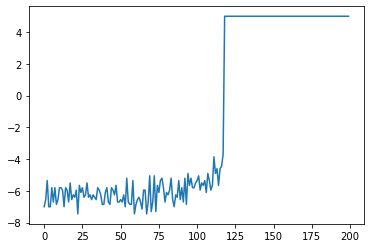

In [374]:
with open('validation_rewards.pkl', 'rb') as f:
    # This file is generated by `train_qlearning.py 500 1`
    validation_rewards = dill.load(f)
validation_rewards.plot()

It is very clear from the very negative average reward that until around 100 episodes, the RL agent has a hard time against the tree. But then quickly the agent becomes good enough to always play the tree to a draw. This shows that with such a Q learning approach you can learn tic-tac-toe in under 150 games played. I am rather impressed by that feat. 

In [404]:
with open('trained_player.pkl', 'rb') as f:
    trained_player = dill.load(f)

/home/paul/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 1751 rows containing missing values.


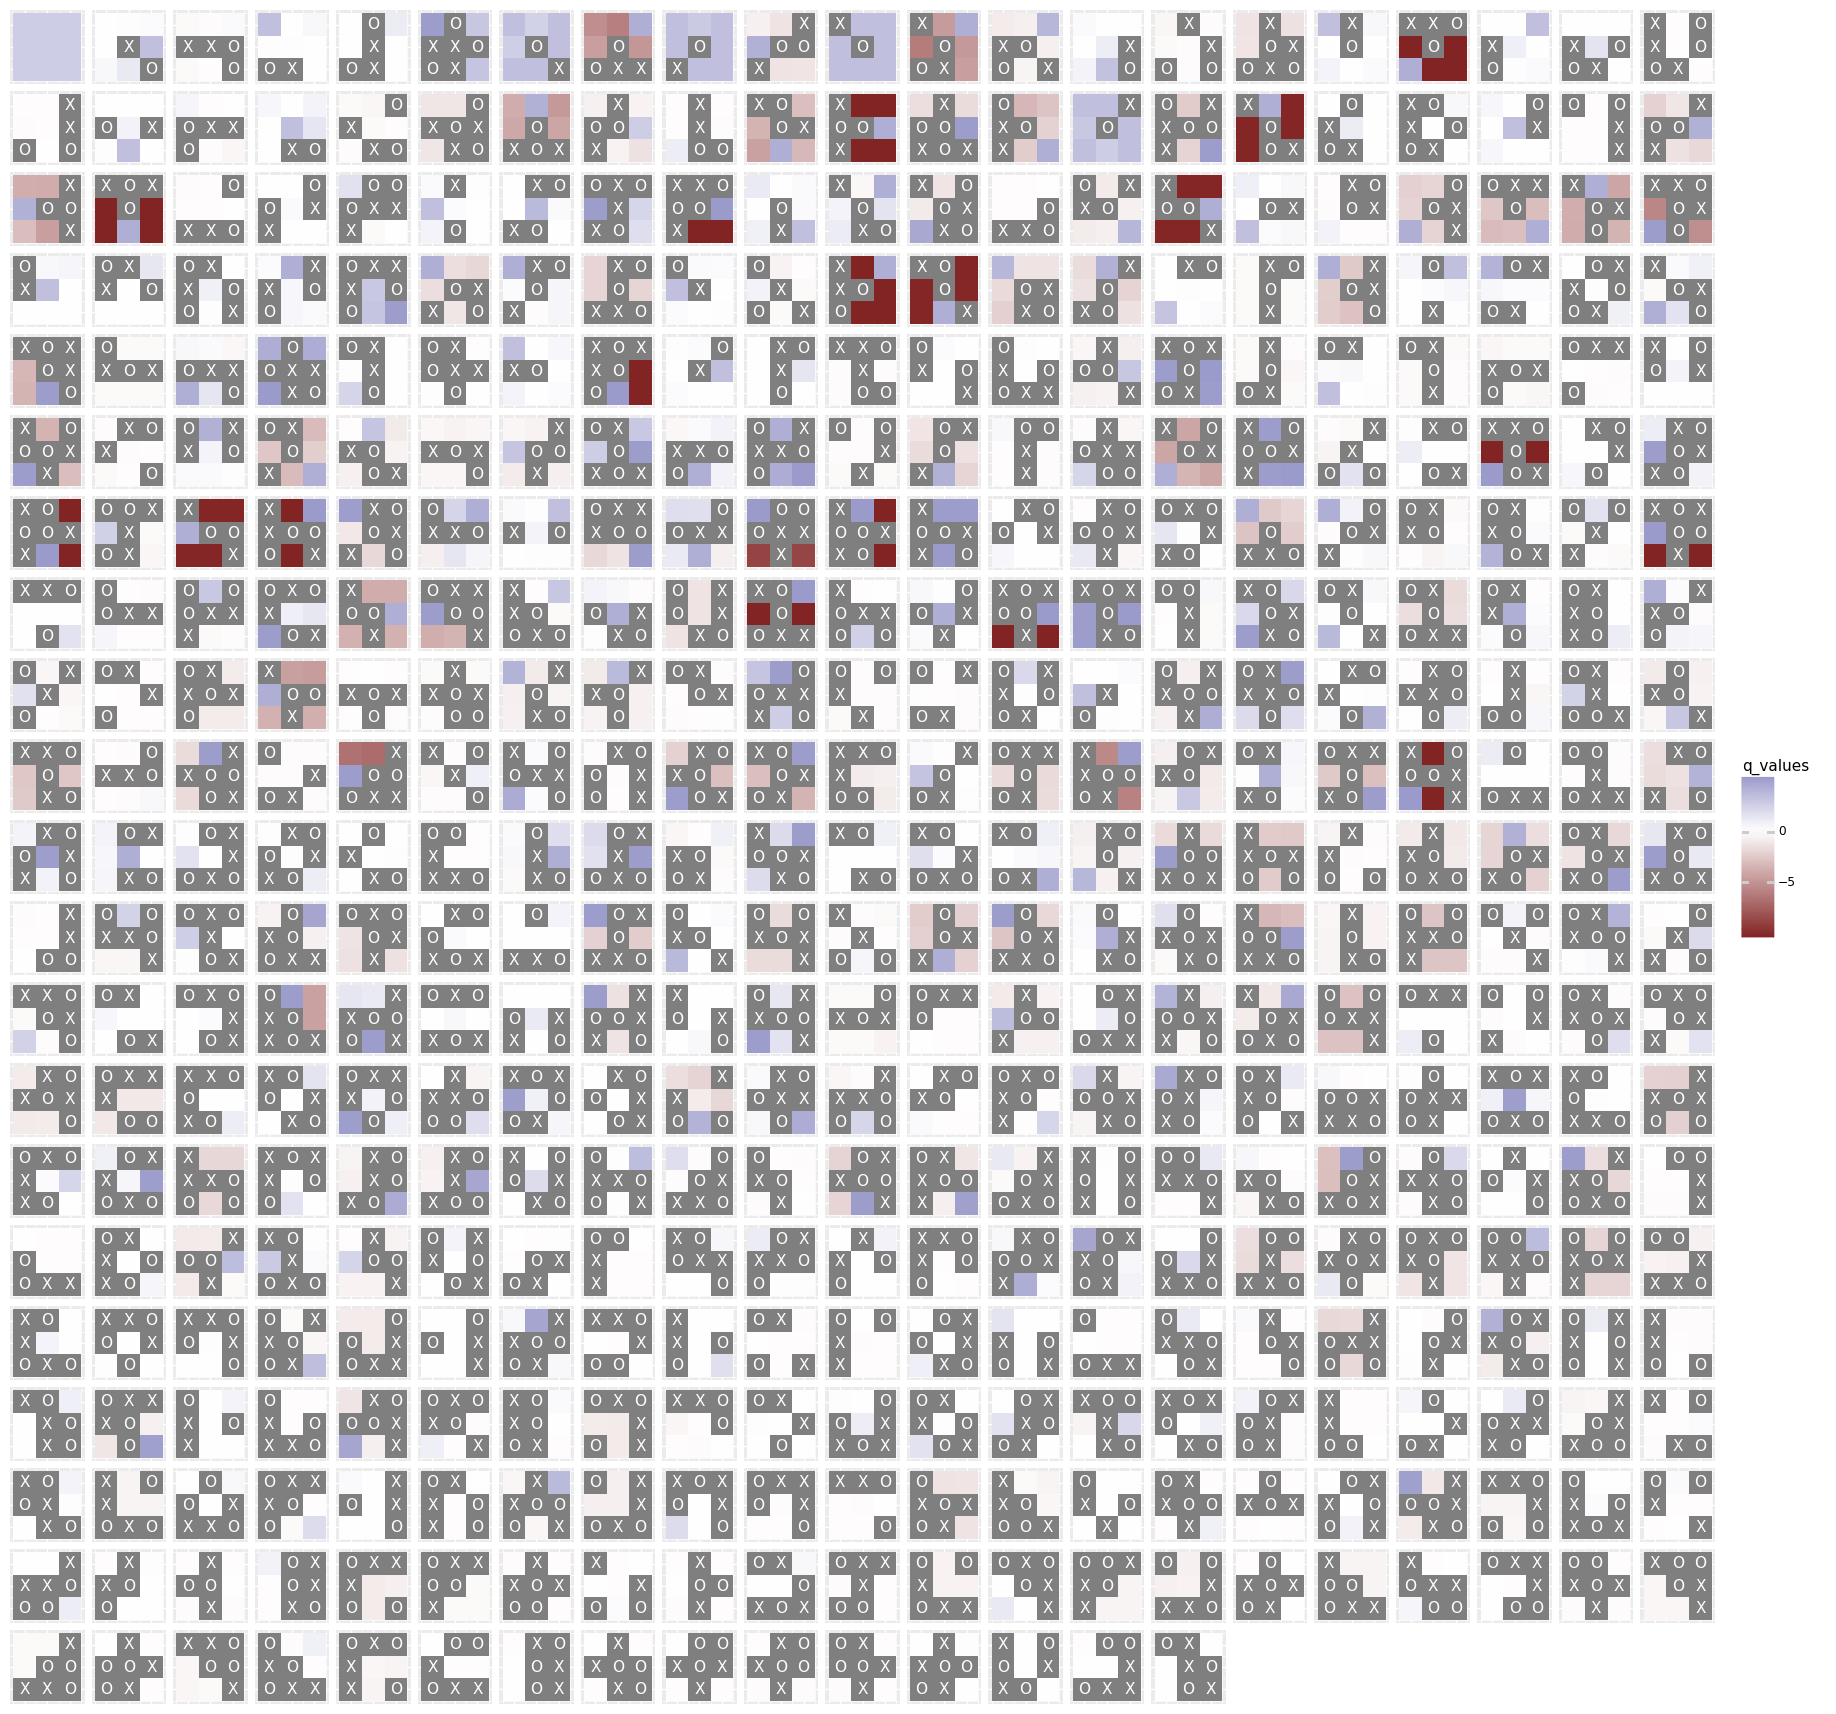

<ggplot: (8727879454582)>

In [405]:
trained_player.plot_qtable()

# Play single games for debugging

In [269]:
tictactoe = Tictoe(3)

In [403]:
import random

trained_player.set_params(epsilon = 0)
while not tictactoe.is_endstate():
    tictactoe = trained_player.make_move(tictactoe)
#    print(tictactoe.get_board())
    tictactoe = trained_player.make_computer_move(tictactoe)
#    print(tictactoe.get_board())
print(tictactoe.get_board())
print(tictactoe.get_reward(1))
tictactoe.reset_board()

[[-1.  1. -1.]
 [-1.  1.  1.]
 [ 0. -1.  1.]]
5
